In [165]:
using Pkg

In [173]:
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("Plots")
Pkg.add("DataStructures")

In [181]:
using DataFrames
using DelimitedFiles
using CSV
using Plots
using DataStructures

Function for plotting Truss

In [182]:
function plot_truss(df)
   p = plot(df[:,1], df[:,2], seriestype = :scatter, markersize=16, lw = 16, label="")
    for i in 1:length(df[:,1])
        for j in 1:length(df[:,2])
           if df[i, j+2] == 1
                plot!(p, [df[i,1],df[j,1]], [df[i,2],df[j,2]], lw=9, color=:black, label="")
           end
        end
    end
    return p
end

plot_truss (generic function with 1 method)

In [183]:
df = CSV.read("data.csv", DataFrame)

,x,y,n1,n2,n3,n4,n5,n6,ddl,Px,Py
,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0.0,0.0,0,1,0,1,1,1,3,0,0
2,0.5,0.0,1,0,1,1,1,1,0,0,-2000
3,1.0,0.0,0,1,0,1,1,1,3,0,0
4,1.0,0.5,1,1,1,0,1,0,0,0,0
5,0.5,0.5,1,1,1,1,0,1,0,0,0
6,0.0,0.5,1,1,1,0,1,0,0,0,0


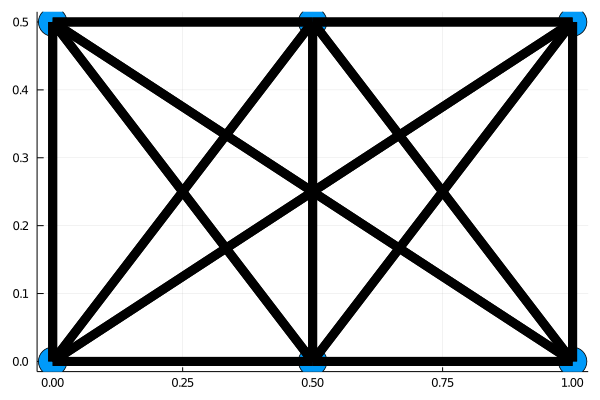

In [184]:
plot_truss(df)

# Partition des degrés de liberté
Cette fonction retourne la localisation des degrés de liberté DDL dans les matrices globales ainsi que les éléments du treillis.

In [282]:
function ddl_vector(truss)
    nbr_ddl = 1; elements = []
    v_ddl = zeros(2*length(truss[:,1]))
    # Vector DDL
    for i in 1:length(truss[:,1])
        if truss[i, 3+length(truss[:,1])] == 0
            v_ddl[2*i-1: 2*i] = [nbr_ddl, nbr_ddl+1]
            nbr_ddl = nbr_ddl + 2
        elseif truss[i, 3+length(truss[:,1])] == 1
            v_ddl[2*i] = nbr_ddl
            nbr_ddl = nbr_ddl + 1
        elseif truss[i, 3+length(truss[:,1])] == 2
            v_ddl[2*i-1] = nbr_ddl
            nbr_ddl = nbr_ddl + 1
        end
    end
    # Truss elements
    for i in 1:length(truss[:,1])-1
        for j in i+3:length(truss[:,1])+2
            if truss[i,j] == 1
               push!(elements,[i,j-2]) 
            end
        end
    end
    return v_ddl, elements
end

ddl_vector (generic function with 1 method)

In [186]:
ddl, elems = ddl_vector(df)

([0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0], Any[[1, 2], [1, 4], [1, 5], [1, 6], [2, 3], [2, 4], [2, 5], [2, 6], [3, 4], [3, 5], [3, 6], [4, 5], [5, 6]])

In [187]:
elems

13-element Array{Any,1}:
 [1, 2]
 [1, 4]
 [1, 5]
 [1, 6]
 [2, 3]
 [2, 4]
 [2, 5]
 [2, 6]
 [3, 4]
 [3, 5]
 [3, 6]
 [4, 5]
 [5, 6]

In [188]:
ddl

12-element Array{Float64,1}:
 0.0
 0.0
 1.0
 2.0
 0.0
 0.0
 3.0
 4.0
 5.0
 6.0
 7.0
 8.0

In [189]:
function longeur_barres(truss)
    L = []
    ddl, e = ddl_vector(truss)
    for i in 1:length(e)
        append!(L,sqrt( (truss.x[e[i][1]] - truss.x[e[i][2]])^2 + (truss.y[e[i][1]] - truss.y[e[i][2]])^2))
    end
    return L
end

longeur_barres (generic function with 1 method)

# Étude élémentaire
Cette fonction retourne les matrices de rigidité élémentaire

In [190]:
function matrice_regidite(truss, E, A, alpha, delta_T)
    K_list = []; ddl_list = []; f_th_list = []; nbr_ddl = 1
    gnr_ddl, elements = ddl_vector(truss)
    cur = 1
    for i in 1:length(truss[:,1])-1
        for j in i+3:length(truss[:,1])+2
            if truss[i,j] ==1
                L = sqrt( (truss.x[i] - truss.x[j-2])^2 + (truss.y[i] - truss.y[j-2])^2)
                nx = (truss.x[i] - truss.x[j-2])/L
                ny = (truss.y[i] - truss.y[j-2])/L
                # Matric de régidité de l'élément (i ==> j-2)
                K  = E*A[cur][1]*[-nx; -ny; nx; ny]*[-nx -ny nx ny]/L
                push!(K_list, K)
                # Vecteur de degré de liberté de l'élémént (i ==> j-2)
                ddl_elem = zeros(4,1)
                ddl_elem[1:2] = gnr_ddl[2*i-1:2*i]
                ddl_elem[3:4] = gnr_ddl[2*j-5:2*j-4]
                push!(ddl_list,ddl_elem)
                # Vecteur force de l'élémént (i ==> j-2)
                f_th = E*A[cur][1]*alpha*delta_T*[-nx; -ny; nx; ny]; cur +=1
                push!(f_th_list,f_th)
            end
        end
    end
    return K_list, ddl_list, f_th_list
end

matrice_regidite (generic function with 1 method)

In [193]:
K_list, ddl_list, f_th_list = matrice_regidite(df,1,[1 1 1 1 1 1 1 1 1 1 1 1 1],0,0)

In [194]:
K_list[1] # La matrice de rigidité de l'élément 1

4×4 Array{Float64,2}:
  2.0  0.0  -2.0  0.0
  0.0  0.0   0.0  0.0
 -2.0  0.0   2.0  0.0
  0.0  0.0   0.0  0.0

In [196]:
ddl_list[1] # Localisation ds degré de liberté de l'élément 1

4×1 Array{Float64,2}:
 0.0
 0.0
 1.0
 2.0

# Assemblage

In [237]:
function assemblage(truss, E, A, alpha, delta_T)
    K_list, ddl_list, f_th_list = matrice_regidite(truss, E, A, alpha, delta_T)
    ddl_vec, elements  = ddl_vector(truss)
    F = []; index_K = []; len_K = 0
    # Vecteur force nodal
    for i in 1:length(ddl_vec)
        if ddl_vec[i] != 0
            len_K += 1
            if mod(i,2) == 0
                append!(F, truss.Py[Int(ceil(i/2))])
            else
                append!(F, truss.Px[Int(ceil(i/2))])
            end
        end
    end
    # Assemblage des matrices de régidité
    K = zeros(len_K, len_K)
    for k in 1:length(ddl_list)
        for i in 1:length(ddl_list[k])
            if ddl_list[k][i] != 0
                for j in 1:length(ddl_list[k])
                    if ddl_list[k][j] != 0
                        K[Int(ddl_list[k][i]),Int(ddl_list[k][j])] += K_list[k][i,j]
                    end
                end
            end
        end
    end
    # Assemblage des vecteur force
    f_th = zeros(len_K)
    for k in 1:length(ddl_list)
        for i in 1:length(ddl_list[k])
            if ddl_list[k][i] != 0
                f_th[Int(ddl_list[k][i])] += f_th_list[k][i]
            end
        end
    end
    # Index K
    for i in 1:length(ddl_vec)
        if Int(ddl_vec[i]) !=0
            if mod(i,2) == 0
                str = "v"*string(Int(ceil(i/2)))
                push!(index_K, str)
            else
                str = "u"*string(Int(ceil(i/2)))
                push!(index_K, str)
            end
        end
    end
    return K, F, f_th, index_K
end

assemblage (generic function with 1 method)

In [239]:
K, F, f_th, index_K = assemblage(df,200000, [1 1 1 1 1 1 1 1 1 1 1 1 1],0,0)

In [241]:
K

8×8 Array{Float64,2}:
       1.08284e6        0.0  -141421.0  …        0.0  -141421.0   141421.0
       0.0         682843.0  -141421.0     -400000.0   141421.0  -141421.0
 -141421.0        -141421.0   684530.0           0.0        0.0        0.0
 -141421.0        -141421.0   212976.0           0.0        0.0        0.0
       0.0              0.0  -400000.0           0.0  -400000.0        0.0
       0.0        -400000.0        0.0  …   682843.0        0.0        0.0
 -141421.0         141421.0        0.0           0.0   684530.0  -212976.0
  141421.0        -141421.0        0.0           0.0  -212976.0   577198.0

In [242]:
F

8-element Array{Any,1}:
     0
 -2000
     0
     0
     0
     0
     0
     0

In [243]:
index_K

8-element Array{Any,1}:
 "u2"
 "v2"
 "u4"
 "v4"
 "u5"
 "v5"
 "u6"
 "v6"

# Calcul des déplacements inconnus
Cette fonction retourne Le vecteur general des déplacements inconnus

In [244]:
function displacement_inconnu(truss, E, A, alpha, delta_T)
    K, F, f_th, index = assemblage(truss, E, A, alpha, delta_T)
    S = inv(K)*(F + f_th)
    ddl, elements = ddl_vector(truss)
    DDL = OrderedDict()
    for i in 1:length(elements)
        push!(DDL,"u"*string(i)=>0 ,"v"*string(i)=>0)
    end
    for i in 1:length(ddl)
        if ddl[i] != 0
            DDL[collect(keys(DDL))[i]] = S[Int(ddl[i])]
        end
    end
    return DDL, elements
end

displacement_inconnu (generic function with 1 method)

In [250]:
ddl, elements = displacement_inconnu(df,200000, [1 1 1 1 1 1 1 1 1 1 1 1 1] ,0,0)

In [252]:
elements

13-element Array{Any,1}:
 [1, 2]
 [1, 4]
 [1, 5]
 [1, 6]
 [2, 3]
 [2, 4]
 [2, 5]
 [2, 6]
 [3, 4]
 [3, 5]
 [3, 6]
 [4, 5]
 [5, 6]

In [253]:
d

OrderedDict{Any,Any} with 26 entries:
  "u1"  => 0
  "v1"  => 0
  "u2"  => -5.29396e-20
  "v2"  => -0.00566664
  "u3"  => 0
  "v3"  => 0
  "u4"  => -0.000834544
  "v4"  => -0.00108047
  "u5"  => 1.05879e-19
  "v5"  => -0.00331944
  "u6"  => 0.000834544
  "v6"  => -0.00108047
  "u7"  => 0
  "v7"  => 0
  "u8"  => 0
  "v8"  => 0
  "u9"  => 0
  "v9"  => 0
  "u10" => 0
  "v10" => 0
  "u11" => 0
  "v11" => 0
  "u12" => 0
  "v12" => 0
  "u13" => 0
  "v13" => 0

# Calcul d'allongement unitaire

In [254]:
function allongement_unitaire(truss, E, A, alpha, delta_T)
    eps_n  = []
    ddl, e = displacement_inconnu(truss, E, A, alpha, delta_T)
    for i in 1:length(e)
        L   = sqrt((truss.x[e[i][1]]-truss.x[e[i][2]])^2+(truss.y[e[i][1]]-truss.y[e[i][2]])^2)
        nx  = (truss.x[e[i][1]] - truss.x[e[i][2]])/L
        ny  = (truss.y[e[i][1]] - truss.y[e[i][2]])/L
        key = collect(keys(ddl))
        eps = (nx*(ddl[key[2*e[i][1]-1]] - ddl[key[2*e[i][2]-1]])+ny*(ddl[key[2*e[i][1]]] - ddl[key[2*e[i][2]]]))/L
        append!(eps_n, eps)
    end
    return eps_n
end

allongement_unitaire (generic function with 1 method)

In [256]:
allongement_unitaire(df,200000, [1 1 1 1 1 1 1 1 1 1 1 1 1],0,0)

13-element Array{Any,1}:
 -1.0587911840678754e-19
 -0.0010998238841267132
 -0.00331944189031121
 -0.002160943935969213
  1.0587911840678754e-19
  0.003751625921554265
  0.0046943997407875
  0.003751625921554265
 -0.0021609439359692134
 -0.00331944189031121
 -0.0010998238841267135
 -0.001669087742332177
 -0.0016690877423321774

# Calcul de l'énérgie de déformation
Cette fonction retourne l'énérgie de déformation de chaque élément

In [257]:
function energie_deformation(truss, E, A, alpha, delta_T)
    E_def  = []; 
    ddl, e = displacement_inconnu(truss, E, A, alpha, delta_T)
    for i in 1:length(e)
        L   = sqrt((truss.x[e[i][1]]-truss.x[e[i][2]])^2+(truss.y[e[i][1]]-truss.y[e[i][2]])^2)
        nx  = (truss.x[e[i][1]] - truss.x[e[i][2]])/L
        ny  = (truss.y[e[i][1]] - truss.y[e[i][2]])/L
        key = collect(keys(ddl))
        eps = (nx*(ddl[key[2*e[i][1]-1]] - ddl[key[2*e[i][2]-1]])+ny*(ddl[key[2*e[i][1]]] - ddl[key[2*e[i][2]]]))/L
        append!(E_def, E*A[i][1]*L*eps*(eps/2 - delta_T))
    end
    return E_def
end

energie_deformation (generic function with 1 method)

In [258]:
E = energie_deformation(df,200000, [1 1 1 1 1 1 1 1 1 1 1 1 1], 0, 0)

13-element Array{Any,1}:
 5.605193857299268e-34
 0.1352387973294166
 0.7791393574718052
 0.2334839347201057
 5.605193857299268e-34
 0.9952313730933328
 1.1018694463152874
 0.9952313730933328
 0.2334839347201058
 0.7791393574718052
 0.13523879732941663
 0.13929269458017618
 0.13929269458017626

L'énérgie total c'est la somme des E_def_i

In [259]:
sum(E)

5.66664176070496

# L'algorithme génétique

Les bibliothèque utilisé

In [260]:
using Statistics
import Base
using StaticArrays;

Les structures utilisé

In [261]:
# L'individu contient une solution son cout
struct Individual
    position
    cost
end
# Un probleme est constitué par fonction fitnesse, nbr var et les bornées
struct Problem
    costfunc
    nvar
    varmin
    varmax
end
# Les parametre d'un probleme
struct Parameter
    maxit
    npop
    beta
    pc
    gamma
    mu
    sugma
end

In [262]:
# Calcul d'exp d'un vecteur
function exp_array(x)
    out = zeros(length(x))
    for i in 1:length(x)
        out[i] = exp(x[i])
    end
    return out
end
# Selection
function roulette_wheel_selection(p)
    c = cumsum(p, dims = 1)
    r = Base.sum(p)*rand()
    ind = 0
    for i in 1:length(c)
        if r <= c[i]
            ind = i
            break
        end
    end
    return ind
end
# Croisement
function  crossover(p1, p2, gamma=0.1)
    c1 = deepcopy(p1)
    c2 = deepcopy(p1)
    alpha = rand(length(c1.position))*(1+2*gamma).-gamma
    c1 = Individual(alpha.*p1.position + (1 .-alpha).*p2.position, c1.cost)
    c2 = Individual(alpha.*p2.position + (1 .-alpha).*p1.position, c2.cost)
    return c1, c2
end
# Mutation
function mutate(x, mu, sugma)
    y = deepcopy(x)
    ind  = []
    for i in 1:length(x.position)
        if rand()<= mu
            append!(ind,i)
        end
    end
    y.position[ind] += sugma*rand(length(ind))
    return y
end
# 
function max_v(array, max)
    for i in 1:length(array)
        if array[i] < max[i]
            array[i] = max[i]
        end
    end
    return array
end
#
function min_v(array, min)
    for i in 1:length(array)
        if array[i] > min[i]
            array[i] = min[i]
        end
    end
    return array
end
# Reglage des bornées
function apply_bound(x, varmin, varmax)
    x = Individual(max_v(x.position, varmin), x.cost)
    x = Individual(min_v(x.position, varmax), x.cost)
    return x
end
# Trie de la population
function sortbycost(pop)
    for i in 1:length(pop)
        for j in 1:length(pop)
            if pop[i].cost < pop[j].cost
                tmp = pop[j]
                pop[j] = pop[i]
                pop[i] = tmp
            end
        end
    end
    return pop
end

sortbycost (generic function with 1 method)

In [263]:
# La fonction du lancement de l'algorithme génétique
function run(problem, params)
    # Problem Information
    costfunc = problem.costfunc
    nvar = problem.nvar
    varmin = problem.varmin
    varmax = problem.varmax

    # Parameters
    maxit = params.maxit
    npop = params.npop
    beta = params.beta
    pc = params.pc
    nc = Int(floor(pc*npop/2)*2)
    gamma = params.gamma
    mu = params.mu
    sugma = params.sugma
    
    # Empty Individual Template
    empty_individual = Individual(Cvoid,Cvoid)
    bestsol = deepcopy(empty_individual)
    # bestsol.cost = Inf
    bestsol = Individual(bestsol.position, Inf)
    
    # Initialize Population
    pop=[]
    for i in 1:npop
       push!(pop,empty_individual)
    end
    for i in 1:npop
        pos = rand(nvar).*(varmax-varmin).+varmin
        costc = costfunc(pos)
        pop[i] = Individual(pos, costc)
        if pop[i].cost < bestsol.cost
            bestsol = deepcopy(pop[i])
        end
    end
    
    # Best Cost of Iterations 
    bestcost = zeros(maxit)
    
    # Main Loop
    for it in 1:maxit
        costs = []
        for i in 1:length(pop)
            append!(costs, pop[i].cost)
        end
        avg_cost = mean(costs)
        if avg_cost != 0
            costs = costs ./avg_cost
        end
        probs = exp_array(-beta.*costs)
        
        popc = []
        for _ in 1:floor(nc/2)
            # Perform Roulette Wheel Selection
            p1 = pop[roulette_wheel_selection(probs)]
            p2 = pop[roulette_wheel_selection(probs)]
            
            # Perform Crossover
            c1, c2 = crossover(p1, p2, gamma)
            
            # Perform Mutation
            c1 = mutate(c1, mu, sugma)
            c2 = mutate(c2, mu, sugma)
            
            # Apply Bounds
            c1 = apply_bound(c1, varmin, varmax)
            c2 = apply_bound(c2, varmin, varmax)
            ## println("c1 = ",c1.position)
            ## println("c2 = ",c2.position)
            
            # Evaluate First Offspring
            c1 = Individual(c1.position, costfunc(c1.position))
            if c1.cost < bestsol.cost
                bestsol = deepcopy(c1)
            end

            # Evaluate Second Offspring
            c2 = Individual(c2.position, costfunc(c2.position))
            if c2.cost < bestsol.cost
                bestsol = deepcopy(c2)
            end
            
            # Add Offsprings to popc
            push!(popc,c1)
            push!(popc,c2)
        end
                
        # Merge, Sort and Select 87
        for i in 1:length(popc)
            push!(pop,popc[i])
        end
        pop = sortbycost(pop)
        pop = deepcopy(pop[1:npop])

        # Store Best Cost
        bestcost[it] = bestsol.cost

        # Show Iteration Information
        println("Iteration "*string(it)*": Best Cost = "*string(bestcost[it]))
    end
    # Output
    # out = Output(pop,bestsol,bestcost)
    return bestsol
end

run (generic function with 1 method)

La fonction fintnesse

In [273]:
function fitness(A)
    truss   = CSV.read("data3.csv", DataFrame)
    E       = 200000
    alpha   =    0
    delta_T =    0
    return sum(energie_deformation(truss, E, A, alpha, delta_T))
end

fitness (generic function with 1 method)

Formulation du problème

In [277]:
costfunc = fitness
nbr_var  =    13
var_min  = [0,0,0,0,0,0,0,0,0,0,0,0,0]
#Nous supposons que l'épaisseur maximale de chaque élément est de 20% de sa longueur. (Air = (0.2*L)*L)
var_max  = 0.2.*longeur_barres(df).^2 

problem = Problem(costfunc, nbr_var, var_min, var_max)

Problem(fitness, 13, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.05, 0.25000000000000006, 0.10000000000000003, 0.05, 0.05, 0.10000000000000003, 0.05, 0.10000000000000003, 0.05, 0.10000000000000003, 0.25000000000000006, 0.05, 0.05])

Les paramètre de l'algorithme génétique

In [275]:
maxit = 100
npop = 50
beta = 1
pc = 1
gamma = 0.1
mu = 0.01
sigma = 0.1

params  = Parameter(maxit, npop, beta, pc, gamma, mu, sigma)

Parameter(100, 50, 1, 1, 0.1, 0.01, 0.1)

# Lancement de l'algorithme génétique

In [284]:
solution = run(problem, params)

Iteration 1: Best Cost = 1413.7836514116973
Iteration 2: Best Cost = 1399.0355204252933
Iteration 3: Best Cost = 1394.826486784574
Iteration 4: Best Cost = 1329.0376994884523
Iteration 5: Best Cost = 1248.4184115353426
Iteration 6: Best Cost = 1248.4184115353426
Iteration 7: Best Cost = 1248.4184115353426
Iteration 8: Best Cost = 1230.239655233126
Iteration 9: Best Cost = 1216.2424366906412
Iteration 10: Best Cost = 1176.9334093236596
Iteration 11: Best Cost = 1176.9334093236596
Iteration 12: Best Cost = 1176.9334093236596
Iteration 13: Best Cost = 1176.9334093236596
Iteration 14: Best Cost = 1176.9334093236596
Iteration 15: Best Cost = 1176.771295546869
Iteration 16: Best Cost = 1172.2066731466214
Iteration 17: Best Cost = 1172.2066731466214
Iteration 18: Best Cost = 1172.2066731466214
Iteration 19: Best Cost = 1171.6886284348016
Iteration 20: Best Cost = 1166.7220852818962
Iteration 21: Best Cost = 1163.6476316182925
Iteration 22: Best Cost = 1163.2667608675147
Iteration 23: Best Cos

Individual([0.04999999999835901, 0.25000000000000006, 0.09999999986281966, 0.02632754935093893, 0.03365252355813212, 0.051860403240192185, 0.035743479230938485, 0.051314898271036365, 0.02202424268679677, 0.059901412024572345, 0.20233127848387233, 0.03121077625365984, 0.037408011207030974], 1160.6601722880343)

In [285]:
solution.position

13-element Array{Float64,1}:
 0.04999999999835901
 0.25000000000000006
 0.09999999986281966
 0.02632754935093893
 0.03365252355813212
 0.051860403240192185
 0.035743479230938485
 0.051314898271036365
 0.02202424268679677
 0.059901412024572345
 0.20233127848387233
 0.03121077625365984
 0.037408011207030974

In [286]:
solution.cost

1160.6601722880343